# Estimating text loss in Middle Dutch chivalric epics

This English-language, Python notebook accompanies the following publication:

> Mike Kestemont and Folgert Karsdorp, "Het Atlantis van de Middelnederlandse ridderepiek. Een schatting van het tekstverlies met methodes uit de ecodiversiteit". *Spiegel der letteren* (2020).

All figures and numbers were prepared using the code below. Future updates of the code and data will be managed in an open [Github repository](https://github.com/mikekestemont/chivalric_diversity). The code block below loads all (third-party) packages and modules necessary to run the module. These can be installed from the file `requirements.txt`.

In [108]:
from functools import partial
from itertools import product

import numpy as np
np.random.seed(12345)
from scipy.special import erfinv
import pandas as pd

import matplotlib.pyplot as plt
#1plt.style.use('./hda.mplstyle')
plt.rcParams["text.usetex"] = False
%matplotlib inline

import scipy.stats as stats
from scipy.special import gammaln

## Data

We load the data from the spreadsheet file `mnl.xlsx`:

In [109]:
mnl = pd.read_excel('mnl.xlsx', header=None, names=('text', 'witness'))
mnl.head(10)

,text,witness
0,Aiol (1),H1
1,Aiol (2),H2
2,Alexanders geesten,"München, Bayerische Staatsbibliotheek, Cod. ge..."
3,Alexanders geesten,H3
4,Alexanders geesten,H4
5,Alexanders geesten,H5
6,Alexanders geesten,H6
7,Arturs doet,"Den Haag, KB, 129 A 10, fol. 201r-238r"
8,Arturs doet,"Rijksarchief te Antwerpen, Sint-Catharinakapit..."
9,Aubri de Borgengoen,H7


We are only interested in the count data, i.e. the number of witnesses per text (the technical term is "abundance data").

In [110]:
mnl.groupby('text').size().sort_values(ascending=False).head()

text
Historie van Troyen       16
Roman van Limborch        10
Madelgijs                 10
Karel ende Elegast         7
Parthonopeus van Bloys     6
dtype: int64

We can extract these as follows:

In [111]:
labels, mnl_counts = np.unique(mnl.groupby('text').size(), return_counts=True)
print(mnl_counts)

[44 13  6  3  3  1  1  2  1]


The counts per text can be plotted as follows:

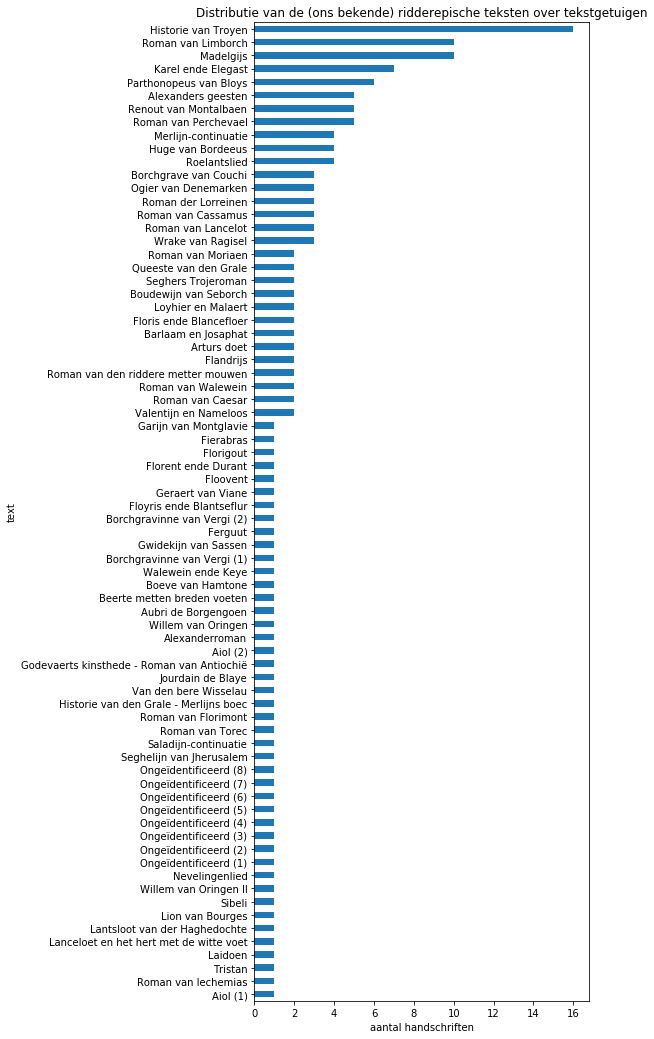

In [112]:
plt.figure(figsize=(6,18))
mnl.groupby('text').size().sort_values(ascending=True).plot.barh(ax=plt.gca());
plt.xlabel('unieke teksten')
plt.xlabel('aantal handschriften')
plt.title('Distributie van de (ons bekende) ridderepische teksten over tekstgetuigen')
plt.savefig('histogram.tiff')

Yet a different perspective is to list the size of the frequency bins that we can distinguish within the manuscript counts:

In [113]:
types = mnl.groupby('text').size().sort_values(ascending=False).value_counts().sort_index()
types = types.to_frame(name='aantal teksten')
types['aantal handschriften'] = types.index

from IPython.display import display, HTML
display(HTML(types.to_html(index=False)))

aantal teksten,aantal handschriften
44,1
13,2
6,3
3,4
3,5
1,6
1,7
2,10
1,16


Finally, we define the auxiliary function `species_richness` to count the number of unique texts in the data (i.e. the number of non-zero counts):

In [114]:
def species_richness(counts):
    return np.sum(counts > 0)

print('# unique texts:', species_richness(mnl.groupby('text').size()))
print('# witnesses:', len(mnl))

# unique texts: 74
# witnesses: 164


## Jackknife

The following function computes the first-order Jackknife estimate, on the basis of the abundance data in our data frame, as well as a confidence interval (.95 be default). This approach is detailed in the following paper:

> K. Burnham & W. Overton, "Robust Estimation of Population Size When Capture Probabilities Vary Among Animals". *Ecology* (1979), 927-936.

In [115]:
def jackknife(data, conf_lvl = .95):
    jack_stat = species_richness(data)
    
    x = np.array(sum([[i]*c for i, c in enumerate(data, 1)], []))
    index = np.arange(x.shape[0])
    
    vals = []
    for i in range(x.shape[0]):
        t = x[index != i]
        vals.append(species_richness(np.bincount(t)))
    
    mean_jack_stat = np.mean(vals)
    bias = (x.shape[0]-1) * (mean_jack_stat - jack_stat)
    
    estimate = jack_stat - bias
    
    std_err = np.sqrt((x.shape[0] - 1) * np.mean((mean_jack_stat - vals) * (mean_jack_stat - vals), axis=0))    
    
    z_score = np.sqrt(2.0) * erfinv(conf_lvl)
    conf_interval = estimate + z_score * np.array((-std_err, std_err))
    
    return estimate, std_err, conf_interval

results = jackknife(mnl.groupby('text').size())
print('jackknife-estimate (order=1):', results[0], results[-1])

jackknife-estimate (order=1): 117.73170731707278 [106.64468284 128.8187318 ]


This implementation is verbose and uses an explicit `for`-loop, which iteratively leaves out observations and tracks the drops in diversity that follow from this operation. In the code blocks below we show that the same estimate can also be obtained in a fully analytical fashion. First we calculate the frequency counts for each unique text:

In [116]:
num_per_text = mnl.groupby('text').size()
num_per_text

text
Aiol (1)                 1
Aiol (2)                 1
Alexanderroman           1
Alexanders geesten       5
Arturs doet              2
                        ..
Van den bere Wisselau    1
Walewein ende Keye       1
Willem van Oringen       1
Willem van Oringen II    1
Wrake van Ragisel        3
Length: 74, dtype: int64

Next, we store the species richness (the number of unique texts) in $t$:

In [117]:
t = species_richness(num_per_text)
t

74

Then we set $s$ to the number of texts that are only attested in a single witness:

In [118]:
s = sum(num_per_text == 1)
s

44

Only the $s$ texts that occur once will affect the species richness during the iterative Jackknife procedure. We can therefore predict that we will obtain the following deviations when applying the bootstrap:

In [119]:
mu = (((t - s) * t) + (s * (t - 1))) / t
mu

73.4054054054054

That means that we can calculate the bias as follows:

In [120]:
bias = (t - 1) * (mu - t)
bias

-43.405405405405546

To account for this bias, we can subtract it from the original species richness in the observed data:

In [121]:
t - bias

117.40540540540555

## Simple example

In [122]:
counts = [5, 4, 3, 3, 1, 1, 1, 1, 1]
names = 'ABCDEFGHI'
data = zip(counts, names)
df = pd.DataFrame(zip(names, counts), columns=('naam', 'mss'))

display(HTML(df.to_html(index=False)))

naam,mss
A,5
B,4
C,3
D,3
E,1
F,1
G,1
H,1
I,1


In [123]:
print('total # of witnesses:', df['mss'].sum())

total # of witnesses: 20


In [124]:
species_richness(df['mss'])

9

In [125]:
jackknife(df['mss'])

(13.75, 1.8874586088176875, array([10.0506491, 17.4493509]))

In [126]:
data = np.array(df['mss'])
x = np.array(sum([[i]*c for i, c in enumerate(data, 1)], []))
tradition = [names[i - 1] for i in x]
print(tradition)

['A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'C', 'C', 'C', 'D', 'D', 'D', 'E', 'F', 'G', 'H', 'I']


In [127]:
bootstrap = []
for i in range(len(tradition)):
    tradition_ = [tradition[j] for j in range(len(tradition)) if i != j]
    
    bootstrap.append((
        (i + 1), tradition[i], ''.join(tradition_),
        len(set(tradition_)), len(set(tradition_)) - len(set(tradition))))

In [128]:
df = pd.DataFrame(bootstrap, columns=('iteration', 'leftout', 'imputed tradition', 'richness', 'error'))
display(HTML(df.to_html(index=False)))

iteration,leftout,imputed tradition,richness,error
1,A,AAAABBBBCCCDDDEFGHI,9,0
2,A,AAAABBBBCCCDDDEFGHI,9,0
3,A,AAAABBBBCCCDDDEFGHI,9,0
4,A,AAAABBBBCCCDDDEFGHI,9,0
5,A,AAAABBBBCCCDDDEFGHI,9,0
6,B,AAAAABBBCCCDDDEFGHI,9,0
7,B,AAAAABBBCCCDDDEFGHI,9,0
8,B,AAAAABBBCCCDDDEFGHI,9,0
9,B,AAAAABBBCCCDDDEFGHI,9,0
10,C,AAAAABBBBCCDDDEFGHI,9,0


In [129]:
mean_estimate = np.mean(df['richness'])
print('gemiddelde schatting:', mean_estimate)
print('afwijking:', mean_estimate - 9)

gemiddelde schatting: 8.75
afwijking: -0.25


In [130]:
bias = 19 * (mean_estimate - 9)
bias

-4.75

In [131]:
corrected = 9 - bias
corrected

13.75

In [132]:
conf_lvl = .95

std_err = np.sqrt(19 * np.mean((mean_estimate - df['richness']) * (mean_estimate - df['richness']), axis=0))    
    
z_score = np.sqrt(2.0) * erfinv(conf_lvl)
conf_interval = corrected + z_score * np.array((-std_err, std_err))
conf_interval

array([10.0506491, 17.4493509])

## Chao1

In the paper we eventually opt for the more recent, non-parametric formula "Chao1", which is described in this paper:

> A. Chao & L. Jost, ‘Estimating diversity and entropy profiles via discovery rates of new species". *Methods in Ecology and Evolution* (2015), 873-882.

Because we have "doubletons" in our data, we use can the following formula, where:
- $\hat{f_0}$ is the (theoretical) number of non-observed species/texts;
- $f_1$ is the number of species/texts attested exactly once ("singletons");
- $f_2$ is the number of species/texts attested exactly twice ("doubletons");
- $n$ is the total number of individuals/manuscripts in the observed data.

\begin{equation}
\hat{f_0} = \frac{(n - 1)}{n} \frac{f_1^2}{2f_2}
\end{equation}

The code block below returns the full, theoretical species richness as etimated by Chao1, i.e. it adds the estimated $\hat{f_0}$ to the species richness that was observed in the sample:

In [133]:
def chao_richness(x):
    x, n = x[x > 0], x.sum()
    t = x.shape[0]
    f1, f2 = (x == 1).sum(), (x == 2).sum()
    return t + (n - 1) / n * ((f1 ** 2 / 2 / f2) if f2 > 0 else (f1 * (f1 - 1) / 2))

If we apply this function to our data, we obtain an even higher (but arguably more realistic) estimate of the loss in textual diversity for this literature. Note, however, that this estimate is still a theoretical *minimum estimate*, since the original loss could still be higher.

In [134]:
chao_richness(num_per_text)

148.00750469043152

Instead of reporting just this number, we apply a bootstrapped procedure in which we sample from the material using a multinomial distribution (see the Appendix Chao and Jost (2015)) and apply Chao1 to the resultiung samples. This procedure allows us to calculate a .95 confidence interval for this value.

In [135]:
def bt_prob(x):
    x, n = x[x > 0], x.sum()
    f1, f2 = (x == 1).sum(), (x == 2).sum()
    C = 1 - f1 / n * (((n - 1) * f1 / ((n - 1) * f1 + 2 * f2)) if f2 > 0 else
                      ((n - 1) * (f1 - 1) / ((n - 1) * (f1 - 1) + 2)) if f1 > 0 else
                      0)
    W = (1 - C) / np.sum(x / n * (1 - x / n) ** n)
    p = x / n * (1 - W * (1 - x / n) ** n)
    f0 = np.ceil(((n - 1) / n * f1 ** 2 / (2 * f2)) if f2 > 0 else
                 ((n - 1) / n * f1 * (f1 - 1) / 2))
    p0 = (1 - C) / f0
    p = np.hstack((p, np.array([p0 for i in np.arange(f0)])))
    return p


def bootstrap(x, n_iter=1000, conf=.95):
    # define a multinomial probability distribution
    # for the bootstrap procedure to sample from:
    p, n = bt_prob(x), x.sum()
    data_bt = np.random.multinomial(n, p, n_iter)
    
    pro = np.array([chao_richness(row) for row in data_bt])
    
    pro_mean = pro.mean(0)
    
    lci_pro = -np.quantile(pro, (1 - conf) / 2, axis=0) + pro_mean
    uci_pro = np.quantile(pro, 1 - (1 - conf) / 2, axis=0) - pro_mean

    sd_pro = np.std(pro, axis=0)

    pro = pro_mean - pro
    return (lci_pro, uci_pro, sd_pro, pro)

In [136]:
def chao_estimate(x, n_iter=1000, conf=0.95):
    pro = chao_richness(x)
    (lci_pro, uci_pro, sd_pro, bt_pro) = bootstrap(x, n_iter=n_iter, conf=conf)
    lci_pro, uci_pro = pro - lci_pro, pro + uci_pro
    bt_pro = pro - bt_pro
    return (lci_pro, uci_pro, bt_pro, pro)

The following block applies this bootstrapped procedure to obtain the final estimates:

In [137]:
lci_pro, uci_pro, bt_pro, pro = chao_estimate(num_per_text, n_iter=10000)
print('pro:', pro)
print('lci_pro:', lci_pro)
print('uci_pro:', uci_pro)

pro: 148.00750469043152
lci_pro: 106.21863495939421
uci_pro: 219.01578019221017


The array `bt_pro` contains the estimates that were collected during the bootstrap (1,000 iterations by default). Below, we plot the distribution of these numbers using a rainplot:

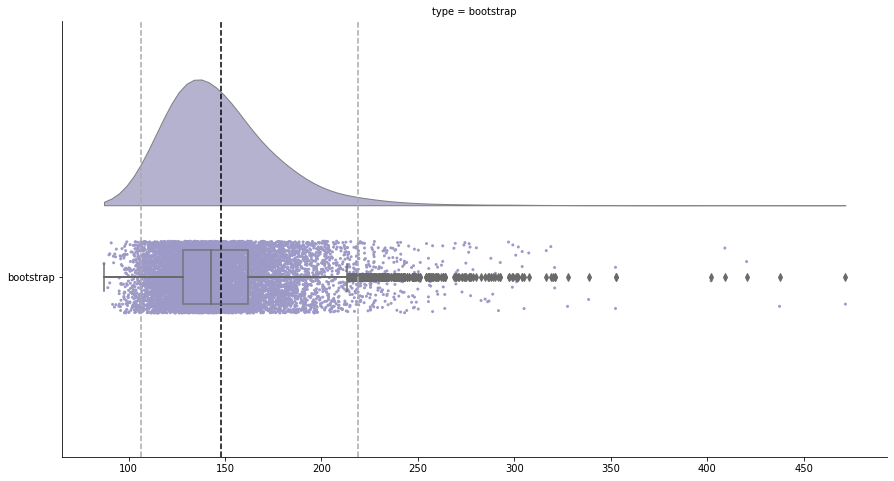

In [138]:
import ptitprince as pt
import seaborn as sns

d = list([(x, 'bootstrap') for x in bt_pro])
bt = pd.DataFrame(d, columns=('bootstrap', 'type'))

g = sns.FacetGrid(bt, col="type", sharey=False, aspect=1.5)
g = g.map_dataframe(pt.RainCloud, x="type", y="bootstrap", data=bt, palette='Purples',
                    orient="h", ax=g.axes, alpha=.8, bw=.3, width_viol=0.7)

g.fig.set_size_inches(15, 8)

plt.gca().axvline(pro, c='black', ls='--');
plt.gca().axvline(uci_pro, c='darkgrey', ls='--');
plt.gca().axvline(lci_pro, c='darkgrey', ls='--');

Het idee dat er minstens 100 teksten waren is geen statistische larie, maar het is een wel erg conservatieve schatting, helemaal onderin het probabiliteitscontinuum. Veel meer aannemelijk is de schatting can ~140 manuscripten (of meer), wat zou betekenen dat *minstens de helft van de ridderepische teksten niet is overgeleverd*. Net zoals 100 een uiterst optimistische schatting is, vormt ~216 de meest pessimistische schatting die we op dit moment kunnen voorop stellen: in dat geval, zou ons slechts een derde van de ooit beschikbare ridderepiek zijn overgeleverd, hetgeen al meer dramatische, maar niet geheel onrealistische cijfers zijn.

## Species accumulation curve

In [139]:
def bootstrap_re(x, fn=chao_richness, n_iter=1000, conf=.95):
    # define a multinomial probability distribution
    # for the bootstrap procedure to sample from:
    p, n = bt_prob(x), x.sum()
    data_bt = np.random.multinomial(n, p, n_iter)
    
    Dq = fn(x)
    
    pro = np.array([fn(row) for row in data_bt])
    
    error = stats.norm.ppf(1 - (1 - conf) / 2) * np.std(pro, 0)
    lci_pro = Dq - error
    uci_pro = Dq + error

    sd_pro = np.std(pro, axis=0)

    return (lci_pro, uci_pro, sd_pro, Dq, )


def rarefaction_extrapolation(x, max_steps):
    x, n = x[x > 0], x.sum()
    def _sub(m):
        if m <= n:
            return np.sum(1 - np.array(
                [np.exp(gammaln(n - i + 1) + gammaln(n - m + 1) - 
                        gammaln(n - i - m + 1) - gammaln(n + 1)) if i <= (n - m) else
                 0 for i in x]))
        else:
            S = (x > 0).sum()
            f1, f2 = (x == 1).sum(), (x == 2).sum()
            f0 = ((n - 1) / n * f1 * (f1 - 1) / 2) if f2 == 0 else ((n - 1) / n * f1**2 / 2 / f2)
            A = n * f0 / (n * f0 + f1)
            return S if f1 == 0 else (S + f0 * (1 - A**(m - n)))
    return np.array([_sub(mi) for mi in range(1, max_steps)])

In [140]:
counts = np.bincount(mnl.groupby('text').size())[1:] # ignore zero
x = np.array(sum([[i]*c for i, c in enumerate(counts, 1)], []))

In [141]:
max_steps = 1000
lci_pro, uci_pro, sd_pro, Dq = bootstrap_re(x, fn=partial(rarefaction_extrapolation, max_steps=max_steps), n_iter=50)

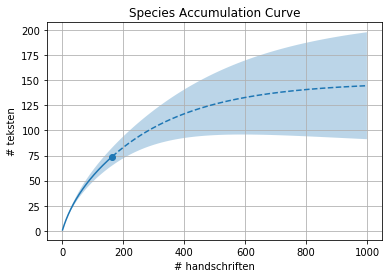

In [142]:
steps = np.arange(1, max_steps)
interpolated = np.arange(1, max_steps) < x.sum()
plt.plot(steps[interpolated], Dq[interpolated], color='C0')
plt.plot(x.sum(), Dq[x.sum() - 1], 'o')
plt.plot(steps[~interpolated], Dq[~interpolated], '--', color='C0')
plt.fill_between(steps, lci_pro, uci_pro, alpha=0.3)
plt.grid()
plt.xlabel('# handschriften')
plt.ylabel('# teksten')
plt.title('Species Accumulation Curve')
plt.savefig('accumulation.tiff')